Ce notebook présente la solution numérique de la dynamique de modèle de Curie-Weiss, décrit par l'Hamiltonien :
$$
H = -\frac{J}{2N}\sum_{i,j} s_i s_j - h \sum_i s_i
$$
où $s_i = \pm 1$ sont des spins d'Ising, $J$ est l'interaction ferromagnétique (que nous fixons à 1), $h$ est le champ magnétique externe, et $N$ est le nombre de spins.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton, root_scalar
import math

**Metropolis**

Voici comment cela fonctionne :

1. Choisir une configuration de départ pour les valeurs des $ N $ spins $ s_i = \pm 1 $ pour $ i=1, \ldots, N $.
2. Choisir un spin $ i $ au hasard. Calculer la valeur actuelle de l'énergie $ E_{\mathrm{now}} $ et la valeur de l'énergie $ E_{\mathrm{flip}} $ si le spin $ i $ est inversé (c'est-à-dire si $ S^{\mathrm{new}}_i = -S^{\mathrm{old}}_i $).
3. Tirer un nombre $ r $ uniformément dans $ [0,1] $ et, si $ r < e^{\beta (E_{\mathrm{now}} - E_{\mathrm{flip}})} $, effectuer l'inversion (c'est-à-dire $ S^{\mathrm{new}}_i = -S^{\mathrm{old}}_i $), sinon, laisser le spin inchangé.
4. Revenir à l'étape 2.


In [2]:
def mag_theo(beta, h, start=-.99):
    def mag(m):
        return math.tanh(beta*(h + m))-m
    return newton(mag, start, tol = 0.001, maxiter=250)

def MCMC_plot(n_list, term, beta, h):
    for n in n_list:
        J = 1/n
        spin = np.ones(n)
        m_temp = np.zeros(term)
        for i in range(term):
            sel = np.random.randint(0,n)
            dE = 2*J*spin[sel]*(spin).sum() + 2*h*spin[sel]
            if np.random.rand() < np.exp(-dE*beta):
                spin[sel] *= -1
            m_temp[i] = spin.mean()
        if n == 10:
            plt.plot(m_temp, label = f'n = {n}', alpha=.5)
        else:
            plt.plot(m_temp, label = f'n = {n}')

    plt.plot(mag_theo(beta, h, 1)*np.ones(term), label = 'Theory', color = 'Black')
    plt.plot(mag_theo(beta, h,-1)*np.ones(term), color = 'Black')

    plt.xlabel('Time')
    plt.ylabel('Magnetization')
    plt.legend()
    plt.xlim(-500,25000)
    plt.title(f'MCMC dynamics for beta = {beta:.3f} (T={1./beta:.3f}), h = {h:.3f}')
    plt.show()

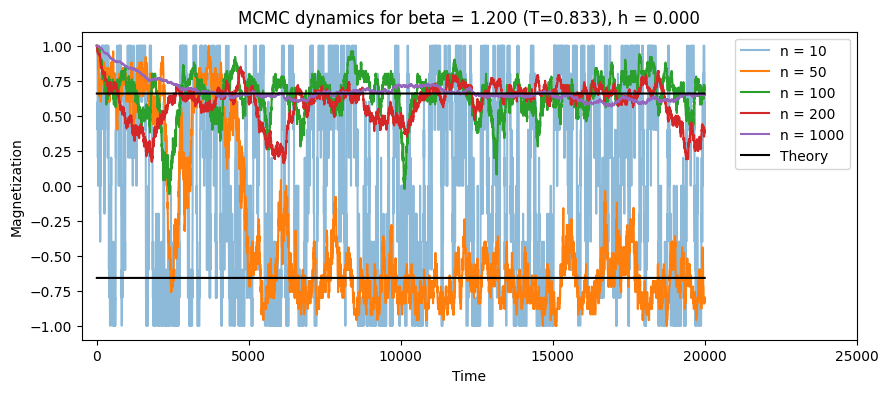

In [3]:
plt.rcParams["figure.figsize"] = (10,4)

n_list = [10, 50, 100, 200, 1000]
term = 20000
beta = 1.2
h = 0

MCMC_plot(n_list, term, beta, h)

Dans cette configuration, nous avons deux minima avec la même énergie. Tout d'abord, rappelons que la "convergence" pour une méthode de Monte Carlo par chaînes de Markov (MCMC) signifie que la distribution de probabilité passe d'un delta dans notre configuration "tout à 1" à la distribution stationnaire, qui, dans ce cas, est localisée dans les deux minima. Pour cette raison, un marcheur individuel finira par sauter entre les deux minima même après la convergence. En outre, il y aura des fluctuations autour des minima dont l'amplitude dépendra de la forme du minimum (plus aigüe pour des valeurs élevées de
𝑁
N). On remarque que pour de petites valeurs de
𝑁
N, les fluctuations rendent très facile le passage entre les minima.

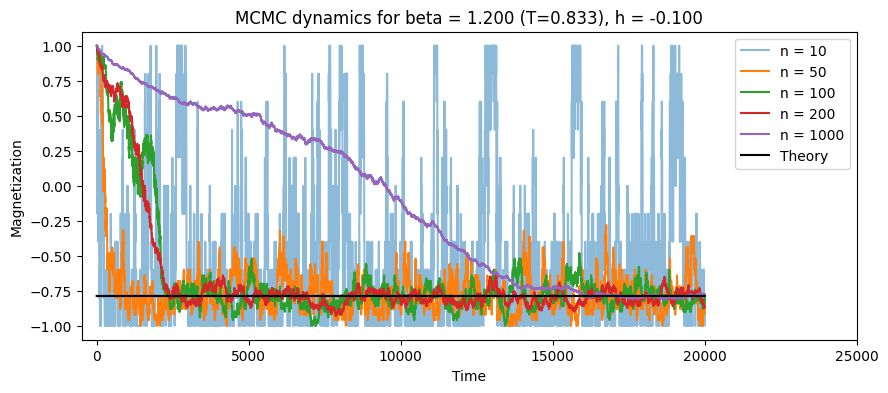

In [4]:
h = -.1
MCMC_plot(n_list, term, beta, h)

Dans ce cas, le champ magnétique $h$ brise la symétrie $pm1$  (étant donné qu'il est négatif, le minimum avec une aimantation négative a une énergie plus faible). Tout ce qui a été dit précédemment s'applique ici également. On peut noter que la convergence (dans le sens où un marcheur unique passe de la configuration initiale au minimum d'aimantation négative) est plus lente pour des valeurs élevées de $n$ car il s'agit d'un algorithme par spin unique.

**Dynamique de Glauber**

- Soit $ \bar{S} = \frac{1}{N} \sum^N_{i=1} s_{i} $ la magnétisation totale d'un système de $ N $ spins. Montrez que, pour tout $ i=1, \cdots, N $, la probabilité d'avoir un spin à $ S_{i} = \pm 1 $, étant donné que tous les autres spins sont fixés, est donnée par :
  $$
  \mathbb{P}\left(S_{i} = \pm 1 \mid \{S_{j}\}_{j\neq i}\right) \equiv P_{\pm} = \frac{1 \pm \tanh(\beta(\bar{S} + h))}{2}
  $$

- L'algorithme de Glauber est défini comme suit :
  1. Choisir une configuration initiale pour les $ N $ spins. Calculer la magnétisation $ m_{t} $ et l'énergie $ E_{t} $ correspondant à cette configuration.
  2. Choisir un spin $ S_{i} $ au hasard. Tirer un nombre aléatoire $ r $ uniformément dans l'intervalle $ [0,1] $. Si $ r < P_{+} $, fixer $ S_{i} = +1 $, sinon fixer $ S_{i} = -1 $. Mettre à jour l'énergie et la magnétisation.
  3. Répéter l'étape 2 jusqu'à convergence.

  

In [5]:
def Glauber_plot(n_list, term, beta, h):
    for n in n_list:
        J = 1/n
        spin = np.ones(n)
        m_temp = np.zeros(term)
        for i in range(term):
            sel = np.random.randint(0,n)
            pi_plus = .5*(1+np.tanh(beta*(spin.mean()+h)))
            spin[sel] = -1
            if np.random.rand() < pi_plus:
                spin[sel] = 1
            m_temp[i] = spin.mean()
        if n == 10:
            plt.plot(m_temp, label = f'n = {n}', alpha=.5)
        else:
            plt.plot(m_temp, label = f'n = {n}')

    plt.plot(mag_theo(beta, h,1)*np.ones(term), label = 'Theory', color = 'Black')
    plt.plot(mag_theo(beta, h,-1)*np.ones(term), color = 'Black')
    
    plt.xlabel('Time')
    plt.ylabel('Magnetization')
    plt.legend()
    plt.xlim(-500,25000)
    plt.title(f'Glauber dynamics for beta = {beta}, h = {h}')
    plt.show()

L'algorithme de Glauber a un comportement a peine différent. Il semble converger plus rapidement, à la fois pour atteindre n'importe quel minimum pour un marcheur et pour atteindre la distribution stable réelle. Cela peut être déduit des fluctuations plus importantes à l'intérieur du minimum, visibles dans le graphique ci-dessous.

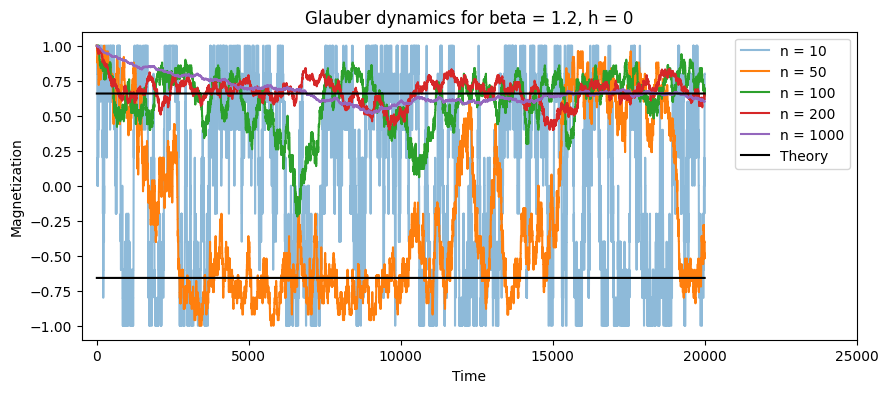

In [6]:
h = 0
Glauber_plot(n_list, term, beta, h)

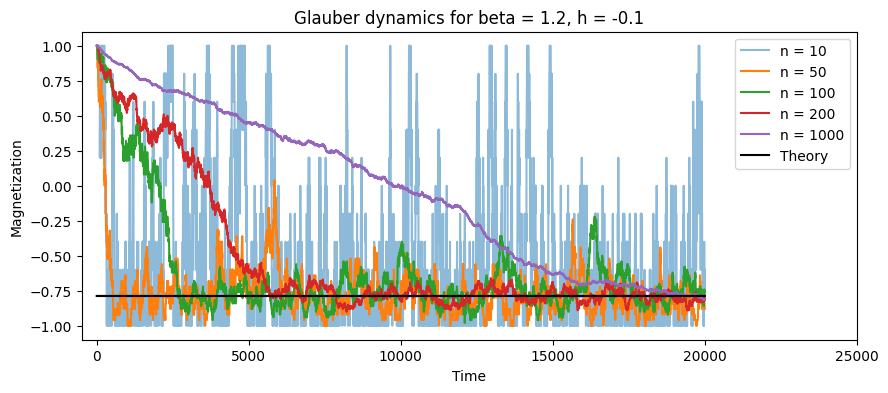

In [7]:
h = -.1
Glauber_plot(n_list, term, beta, h)

# Part II

On montre que dans la limite thermodynamique, on a

$$
  \frac{d}{dt}\langle m(t)\rangle=-\langle m(t)\rangle+\tanh\langle m(t)\rangle
  $$

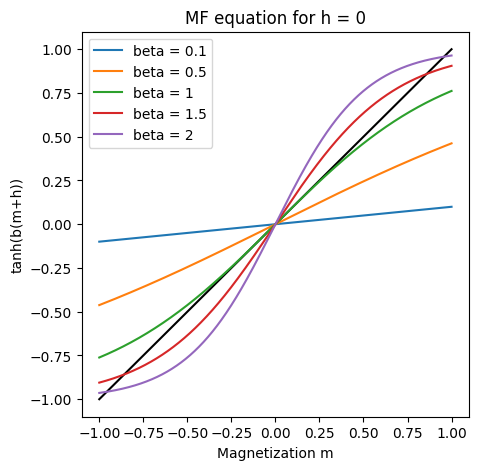

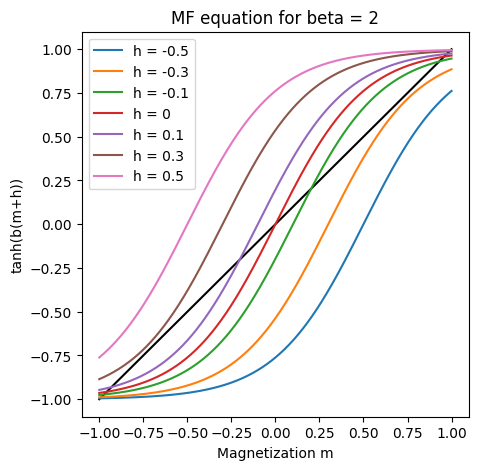

In [8]:
plt.rcParams["figure.figsize"] = (5,5)

x_base = np.linspace(-1,1,1024)
plt.plot(x_base, x_base, color = 'black')
plt.plot(x_base, np.tanh(.1*(x_base)), label = f'beta = {.1}')
plt.plot(x_base, np.tanh(.5*(x_base)), label = f'beta = {.5}')
plt.plot(x_base, np.tanh(1*(x_base)), label = f'beta = {1}')
plt.plot(x_base, np.tanh(1.5*(x_base)), label = f'beta = {1.5}')
plt.plot(x_base, np.tanh(2*(x_base)), label = f'beta = {2}')
plt.legend()
plt.xlabel('Magnetization m')
plt.ylabel('tanh(b(m+h))')
plt.title('MF equation for h = 0')
plt.show()

plt.plot(x_base, x_base, color = 'black')
plt.plot(x_base, np.tanh(2*(x_base-.5)), label = f'h = {-0.5}')
plt.plot(x_base, np.tanh(2*(x_base-.3)), label = f'h = {-0.3}')
plt.plot(x_base, np.tanh(2*(x_base-.1)), label = f'h = {-0.1}')
plt.plot(x_base, np.tanh(2*(x_base)), label = f'h = {0}')
plt.plot(x_base, np.tanh(2*(x_base+.1)), label = f'h = {0.1}')
plt.plot(x_base, np.tanh(2*(x_base+.3)), label = f'h = {0.3}')
plt.plot(x_base, np.tanh(2*(x_base+.5)), label = f'h = {0.5}')
plt.legend()
plt.xlabel('Magnetization m')
plt.ylabel('tanh(b(m+h))')
plt.title('MF equation for beta = 2')
plt.show()

Nous pouvons voir que dans le cas sans champ magnétique, il y a une transition de phase pour $\beta=1$ Nous pouvons également considérer ces graphiques comme un moyen d'étudier les points d'équilibre des équations de champ moyen : pour $\beta<1$ nous avons un équilibre stable, tandis que pour $\beta>1$, nous avons trois points d'équilibre, dont deux sont stables (celui à zéro est instable).

Dans le cas avec champ magnétique, nous nous restreignons à étudier des systèmes avec des champs magnétiques négatifs en raison de la symétrie $\pm1$. Fixons $\beta>1$, pour $h$ plus négatif qu'un certain seuil, nous avons un seul point d'équilibre stable, sinon nous en avons deux comme précédemment. Ce seuil est appele la "spinodale".

D'abord on comence avec le calcul analytique du point "spinodale" pour $h>0$.

In [17]:
beta_fix = 2.0

def func(h, beta):
    def f(m):
        return beta * (1 - math.tanh(beta * (m + h)) ** 2) - 1

    m_found = root_scalar(f, bracket=[-500.0, 0], maxiter=250, xtol=1e-6).root

    return math.tanh(beta * (m_found + h)) - m_found

print(func(0.0, beta_fix), func(0.1, beta_fix), func(0.2, beta_fix), func(0.3, beta_fix))

h_spinodal = root_scalar(func, bracket=[0, 0.3], args=(beta_fix)).root
print(h_spinodal)

-0.266419987676776 -0.1664199876767548 -0.06641998767677548 0.03358001232322394
0.26641998767677605


In [18]:
def ode_glauber(beta, h, dt, sample, start = 1):
    m_list = start * np.ones(sample)
    for i in range(1,sample):
        m_list[i] = m_list[i-1] + dt*(math.tanh(beta*(m_list[i-1]+h)) - m_list[i-1])
    return m_list

def Glauber_theory(n, term, beta, h, state, color):
    J = 1/n
    spin = state*np.ones(n)
    m_temp = np.zeros(term)
    for i in range(term):
        sel = np.random.randint(0,n)
        pi_plus = .5*(1+np.tanh(beta*(spin.mean()+h)))
        spin[sel] = -1
        if np.random.rand() < pi_plus:
            spin[sel] = 1
        m_temp[i] = spin.mean()
    plt.plot(m_temp, color = color)


def Glauber_theory_m(n, term, beta, h, m, color):
    J = 1/n
    spin = np.ones(n)
    spin[:int((1-m)*n/2)] *= -1
    m_temp = np.zeros(term)
    for i in range(term):
        sel = np.random.randint(0,n)
        pi_plus = .5*(1+np.tanh(beta*(spin.mean()+h)))
        spin[sel] = -1
        if np.random.rand() < pi_plus:
            spin[sel] = 1
        m_temp[i] = spin.mean()
    plt.plot(m_temp, color = color)

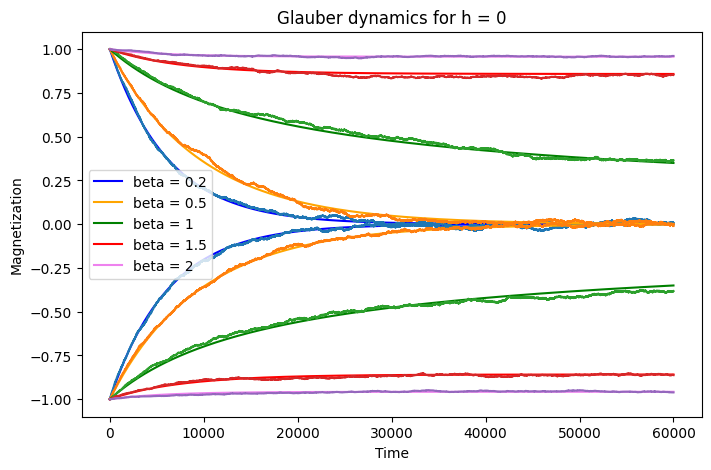

In [19]:
plt.rcParams["figure.figsize"] = (8,5)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

n = 5000
term_beta = 3*term


beta = .2
plt.plot(ode_glauber(beta, h=0, dt=1/n, sample=term_beta), color = 'blue', label=f'beta = {beta}')
plt.plot(ode_glauber(beta, h=0, dt=1/n, sample=term_beta, start=-1), color = 'blue')
Glauber_theory(n, term_beta, beta, h=0, state=1, color=cycle[0])
Glauber_theory(n, term_beta, beta, h=0, state=-1, color=cycle[0])

beta = .5
plt.plot(ode_glauber(beta, h=0, dt=1/n, sample=term_beta), color = 'orange', label=f'beta = {beta}')
plt.plot(ode_glauber(beta, h=0, dt=1/n, sample=term_beta, start=-1), color = 'orange')
Glauber_theory(n, term_beta, beta, h=0, state=1, color=cycle[1])
Glauber_theory(n, term_beta, beta, h=0, state=-1, color=cycle[1])

beta = 1
plt.plot(ode_glauber(beta, h=0, dt=1/n, sample=term_beta), color = 'green', label=f'beta = {beta}')
plt.plot(ode_glauber(beta, h=0, dt=1/n, sample=term_beta, start=-1), color = 'green')
Glauber_theory(n, term_beta, beta, h=0, state=1, color=cycle[2])
Glauber_theory(n, term_beta, beta, h=0, state=-1, color=cycle[2])

beta = 1.5
plt.plot(ode_glauber(beta, h=0, dt=1/n, sample=term_beta), color = 'red', label=f'beta = {beta}')
plt.plot(ode_glauber(beta, h=0, dt=1/n, sample=term_beta, start=-1), color = 'red')
Glauber_theory(n, term_beta, beta, h=0, state=1, color=cycle[3])
Glauber_theory(n, term_beta, beta, h=0, state=-1, color=cycle[3])

beta = 2
plt.plot(ode_glauber(beta, h=0, dt=1/n, sample=term_beta), color = 'violet', label=f'beta = {beta}')
plt.plot(ode_glauber(beta, h=0, dt=1/n, sample=term_beta, start=-1), color = 'violet')
Glauber_theory(n, term_beta, beta, h=0, state=1, color=cycle[4])
Glauber_theory(n, term_beta, beta, h=0, state=-1, color=cycle[4])

plt.legend()
plt.xlabel('Time')
plt.ylabel('Magnetization')
plt.title('Glauber dynamics for h = 0')
plt.show()

Nous superposons les solutions des équations de champ moyen avec les résultats des simulations. Nous choisissons des conditions initiales avec différentes aimantations. Dans ce cas, il n'y a pas de minima sous-optimaux de l'énergie car il n'y a pas de champ magnétique. On peut clairement observer la transition de phase.

/Users/matteovilucchio/Documents/GitHub/IdePHICS/PHYS338private/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


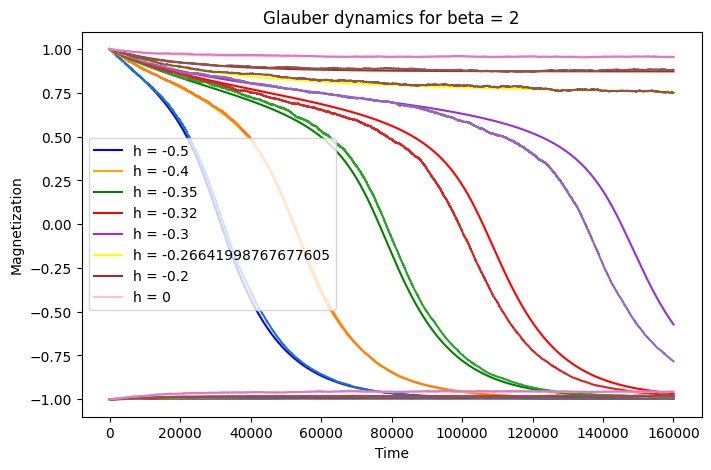

In [21]:
plt.rcParams["figure.figsize"] = (8,5)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

n = 13000
term_beta = 8*term


beta = 2
h = -.5
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta), color = 'blue', label=f'h = {h}')
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta, start=-1), color = 'blue')
Glauber_theory(n, term_beta, beta, h, state=1, color=cycle[0])
Glauber_theory(n, term_beta, beta, h, state=-1, color=cycle[0])

h = -.4
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta), color = 'orange', label=f'h = {h}')
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta, start=-1), color = 'orange')
Glauber_theory(n, term_beta, beta, h, state=1, color=cycle[1])
Glauber_theory(n, term_beta, beta, h, state=-1, color=cycle[1])

h = -.35
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta), color = 'green', label=f'h = {h}')
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta, start=-1), color = 'green')
Glauber_theory(n, term_beta, beta, h, state=1, color=cycle[2])
Glauber_theory(n, term_beta, beta, h, state=-1, color=cycle[2])

h = -.32
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta), color = 'red', label=f'h = {h}')
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta, start=-1), color = 'red')
Glauber_theory(n, term_beta, beta, h, state=1, color=cycle[3])
Glauber_theory(n, term_beta, beta, h, state=-1, color=cycle[3])

h = -.3
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta), color = 'darkorchid', label=f'h = {h}')
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta, start=-1), color = 'darkorchid')
Glauber_theory(n, term_beta, beta, h, state=1, color=cycle[4])
Glauber_theory(n, term_beta, beta, h, state=-1, color=cycle[4])

h = -h_spinodal
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta), color = 'yellow', label=f'h = {h}')
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta, start=-1), color = 'yellow')
Glauber_theory(n, term_beta, beta, h, state=1, color=cycle[5])
Glauber_theory(n, term_beta, beta, h, state=-1, color=cycle[5])

h = -.2
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta), color = 'brown', label=f'h = {h}')
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta, start=-1), color = 'brown')
Glauber_theory(n, term_beta, beta, h, state=1, color=cycle[5])
Glauber_theory(n, term_beta, beta, h, state=-1, color=cycle[5])

h = 0
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta), color = 'pink', label=f'h = {h}')
plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta, start=-1), color = 'pink')
Glauber_theory(n, term_beta, beta, h, state=1, color=cycle[6])
Glauber_theory(n, term_beta, beta, h, state=-1, color=cycle[6])

plt.legend()
plt.xlabel('Time')
plt.ylabel('Magnetization')
plt.title('Glauber dynamics for beta = 2')
plt.show()

Here we study the case with a magnetic field. For h approximately more negative then -0.3 we have only one stable equilibrium point. In case h > -0.3 we have two stable points, but as we can see we only reach the 'closest' one (meaning the one with closer magnetization), not the optimal one. We can see that there is not a perfect agreement between the MF equation and the simulation for h approximately -0.3, which is mostly because the system is really sensible to perturbations (as it can be seen from the MF fixed point equation graph above)

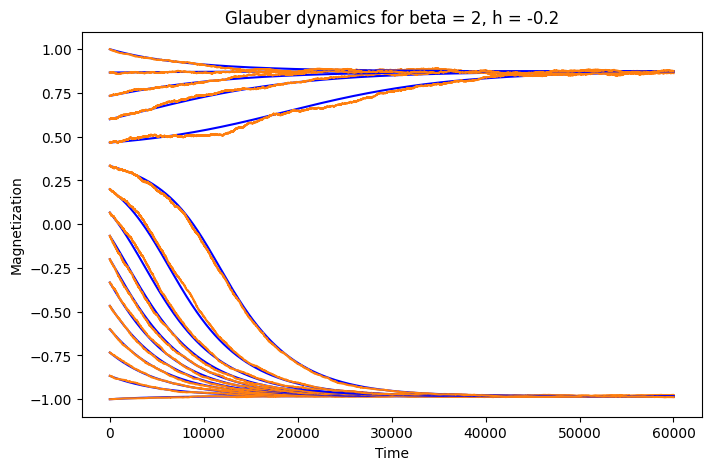

In [22]:
n = 5000
term_beta = 3*term

beta = 2
h = -.2
start_list = np.linspace(-1,1,16)

for start in start_list:
    plt.plot(ode_glauber(beta, h, dt=1/n, sample=term_beta, start=start), color = 'blue')
    Glauber_theory_m(n, term_beta, beta, h, start, color=cycle[1])

plt.xlabel('Time')
plt.ylabel('Magnetization')
plt.title(f'Glauber dynamics for beta = {beta}, h = {h}')
plt.show()

Here we see this effect even more clearly. For some initial configurations we reach a state of the system that is not the global minimum of the energy. This is also seen by just observing the MF equations and noticing that they have more then one stable equilibrium points, so we are bound to have some initial conditions that converge to a non optimal minimum.